# Homework set 3

(Due Mar 3., 2023 at Noon)

Submit your solution notebook in your directory via github PR.

## Problem 1 (100 pts)

Our Colloquium speaker a couple of weeks ago, Ashley Villar, has had to use MCMC extensively. She had something like 5,243 objects from Pan-STARRS to analyze after all (https://zenodo.org/record/3974950)

You'll only have to deal with two - the two that are in this directory

In [1]:
!ls *snana.dat

PS1_PS1MD_PSc000098.snana.dat PS1_PS1MD_PSc000174.snana.dat


She used equation 1, defined here: https://arxiv.org/abs/1905.07422

# $ F= \begin{cases}\frac{A+\beta\left(t-t_0\right)}{1+e^{-\left(t-t_0\right) / \tau_{\text {rise }}}} & t<t_1 \\ \frac{\left(A+\beta\left(t_1-t_0\right)\right) e^{-\left(t-t_1\right) / \tau_{\text {fall }}}}{1+e^{-\left(t-t_0\right) / \tau_{\text {rise }}}} & t \geq t_1\end{cases} $

to model the *flux*, $F$, of a supernova in some band, at times, $t$.

You can see the fits Ashley derived here:

<img src="examples.jpg">

As Bayesians, we have 4 questions to answer:

    1) What's the model?
    2) What's the Likelihood?
    3) What's the Prior?
    4) How do you sample?

I've told you 1 (eqn. 1 in Villar), and you've already guessed 4 (use `emcee`: https://emcee.readthedocs.io/en/stable/). 

Write some functions to implement the model, likelihood and priors, and use `emcee` to sample the posterior with 20 walkers and however many steps you feel is necessary for the burn-in and chain. (50 pts - 15 each for the model, likelihood, priors and 5 to sample) 
 
Show that the posterior is reasonable by generating a corner plot with the `corner` package. (10 pts)

Get the median estimate for each parameter, and recreate the plot above from Ashley. Note that she's made 5 random draws from the chain for each passband to give the reader a sense for the uncertainties. (25 pts)

Report the auto-correlation length of your chain. Thin it by a factor of 10 and report the auto-correlation length again. (15 pts)

In [2]:
%matplotlib inline
import numpy as np
import scipy.stats as st
import scipy.optimize as so
import matplotlib.pyplot as plt
import emcee
import corner
import astropy.table as at
from astropy.io import ascii
import pandas as pd

def model(t, tau_rise, tau_fall, t_0, A, beta, c, gamma):
    t_1 = t_0 + gamma
    md = np.piecewise(t, [t < t_1, t >= t_1], [model1, model2], tau_rise, tau_fall, t_0, A, beta, c, t_1)
    return np.nan_to_num(md) # try nan to num if broken


def model1(t, tau_rise, tau_fall, t_0, A, beta, c, t_1):
    md = c + (A + beta * (t - t_0)) / (1 + np.exp(-(t - t_0) / tau_rise))
    return md


def model2(t, tau_rise, tau_fall, t_0, A, beta, c, t_1):
    md = c + (A + beta * (t - t_0)) * np.exp(-(t - t_1) / tau_fall) / (1 + np.exp(-(t - t_0) / tau_rise))
    return md


def log_prior(tau_rise, tau_fall, t_0, A, beta, c, gamma, t_min, t_max, sigma, F_max, F_max_t):
    if (tau_rise < 0.01 or tau_rise > 50) or\
        (tau_fall < 1 or tau_fall > 300) or\
        (t_0 < F_max_t - 200 or t_0 > F_max_t + 200) or \
        (A < 0.1 * F_max or A > 2 * F_max) or\
        (beta < -F_max / 150 or beta > 0) or\
        (c < -3 * sigma or c > 3 * sigma) or\
        (gamma < -10 or gamma > 150): # Altered from paper: t_0, A
        return -np.inf
    pr = ((2./3.)*st.norm.pdf(gamma, loc=5, scale=5)) + ((1./3.)*st.norm.pdf(gamma, loc=60, scale=30))
    return np.log(pr) # also try normalizing all the flat priors if things are broken


def red_chi2(t, F, dF, tau_rise, tau_fall, t_0, A, beta, c, gamma):
    mod = model(t, tau_rise, tau_fall, t_0, A, beta, c, gamma)
    rc2 = np.sum(((F - mod)**2.)/(dF**2.))/(len(t) - 4)
    return rc2


def log_likelihood(t, F, dF, tau_rise, tau_fall, t_0, A, beta, c, gamma):
    negloglike = red_chi2(t, F, dF, tau_rise, tau_fall, t_0, A, beta, c, gamma) * (len(t) - 4)
    return -negloglike/2.


def log_posterior(params, t=None, F=None, dF=None, t_min=None, t_max=None, sigma=None, F_max=None, F_max_t=None):
    tau_rise, tau_fall, t_0, A, beta, c, gamma = params
    lgpr = log_prior(tau_rise, tau_fall, t_0, A, beta, c, gamma, t_min, t_max, sigma, F_max, F_max_t)
    lgli = log_likelihood(t, F, dF, tau_rise, tau_fall, t_0, A, beta, c, gamma)
    return lgpr + lgli


def run_emcee(data, ndim, nwalkers, nsteps):
    sigma = np.average(data['FLUXCALERR']) / 3 # A GUESS
    t_min = np.amin(data['MJD'])
    t_max = np.amax(data['MJD'])
    F_max = np.amax(data['FLUXCAL'])
    F_max_t = data[data['FLUXCAL'] == F_max]['MJD']
    kwargs = {'t':data['MJD'], 'F':data['FLUXCAL'], 'dF':data['FLUXCALERR'], 't_min':t_min, 't_max':t_max, 
              'sigma':sigma, 'F_max':F_max, 'F_max_t':F_max_t}
    nburn = nsteps // 10 
    
    np.random.seed(10)
    starting_guesses = np.zeros((nwalkers, ndim))
    starting_guesses[:, 0] = 0.01 + 49.99 * np.random.rand(nwalkers) # tau_rise
    starting_guesses[:, 1] = 1 + 99 * np.random.rand(nwalkers) # tau_fall
    starting_guesses[:, 2] = F_max_t - 200 + 400 * np.random.rand(nwalkers) # t_0
    starting_guesses[:, 3] = 0.1 * F_max + (1.9 * F_max) * np.random.rand(nwalkers) # A
    starting_guesses[:, 4] = -F_max / 150 * np.random.rand(nwalkers) # beta
    starting_guesses[:, 5] = -3 * sigma + (6 * sigma) * np.random.rand(nwalkers) # c
    starting_guesses[:, 6] = (2./3.) * np.random.normal(5, 5, (nwalkers)) + (1./3.) * np.random.normal(60, 30, (nwalkers)) # gamma
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, kwargs=kwargs)
    state = sampler.run_mcmc(starting_guesses, nburn) # burning in
    sampler.reset()
    
    sampler.run_mcmc(state, nsteps, progress=True);
    return sampler


def make_corner(sampler, labels):
    samples = sampler.get_chain(flat=True)
    fig = corner.corner(samples, plot_contours=True, show_titles=True, smooth=2, labels=labels)
    return


def make_fig(data, sampler):
    samples = sampler.get_chain(flat=True)
    mcmc_res = np.percentile(samples, [50, 16, 84], axis=0)
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)

    ax.errorbar(data['MJD'], data['FLUXCAL'], yerr=data['FLUXCALERR'],
                linestyle='None', marker='.', color='k', alpha=0.1)
    tmin, tmax = ax.get_xlim()
    tarr = np.linspace(tmin, tmax+0.1, 1000)
    
    ax.fill_between(tarr, model(tarr, *mcmc_res[1]), model(tarr, *mcmc_res[2]), color='C2', alpha=0.3)

    ax.plot(tarr, model(tarr, *mcmc_res[0]), ls='-', color='C1', label='MCMC Result')

    ax.set_xlabel('HJD')
    ax.set_ylabel('F')
    ax.legend()
    #fig.autofmt_xdate()
    return

#print(np.amax(data098[data098['FLT'] == 'g']['FLUXCAL']))
#best_guesses_1g = [2.236, 60.83, 5.517E4, 1.335E3, -1.480, 15.04, 4.586]

In [3]:
data098 = ascii.read('PS1_PS1MD_PSc000098.snana.dat', data_start=12, data_end=-1, comment='#', delimiter=' ', format='csv', 
                     names=['VARLIST:', 'MJD', 'FLT', 'FIELD', 'FLUXCAL', 'FLUXCALERR', 'MAG', 'MAGERR'])
data174 = ascii.read('PS1_PS1MD_PSc000174.snana.dat', data_start=12, data_end=-1, comment='#', delimiter=' ', format='csv', 
                     names=['VARLIST:', 'MJD', 'FLT', 'FIELD', 'FLUXCAL', 'FLUXCALERR', 'MAG', 'MAGERR'])
#print(at.unique(data098, keys='FLT'))

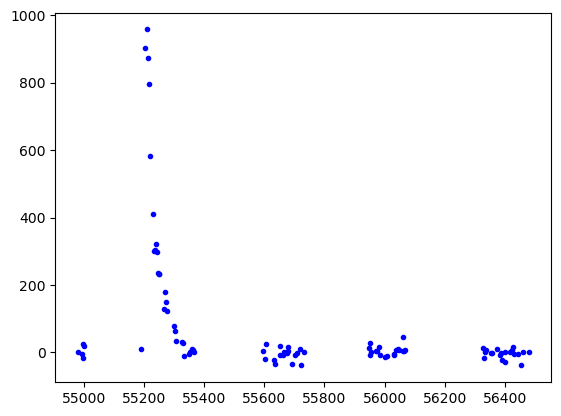

In [4]:
data = data098[data098['FLT'] == 'g']
plt.plot(data['MJD'], data['FLUXCAL'], 'b.')

In [5]:
ndim = 7
nwalkers = 20
nsteps = 10000
datas = [data098, data174]
bands = ['g', 'i', 'r', 'z']
prms = ['tau_rise', 'tau_fall', 't_0', 'A', 'beta', 'c', 'gamma']
samp1 = run_emcee(data, ndim, nwalkers, nsteps)

/var/folders/22/dh8f6qrs5xxcjd4nzyck348r0000gn/T/ipykernel_54393/1219014390.py:19: RuntimeWarning: overflow encountered in exp
  md = c + (A + beta * (t - t_0)) / (1 + np.exp(-(t - t_0) / tau_rise))
/var/folders/22/dh8f6qrs5xxcjd4nzyck348r0000gn/T/ipykernel_54393/1219014390.py:24: RuntimeWarning: overflow encountered in exp
  md = c + (A + beta * (t - t_0)) * np.exp(-(t - t_1) / tau_fall) / (1 + np.exp(-(t - t_0) / tau_rise))
/var/folders/22/dh8f6qrs5xxcjd4nzyck348r0000gn/T/ipykernel_54393/1219014390.py:43: RuntimeWarning: overflow encountered in square
  rc2 = np.sum(((F - mod)**2.)/(dF**2.))/(len(t) - 4)
/var/folders/22/dh8f6qrs5xxcjd4nzyck348r0000gn/T/ipykernel_54393/1219014390.py:24: RuntimeWarning: overflow encountered in multiply
  md = c + (A + beta * (t - t_0)) * np.exp(-(t - t_1) / tau_fall) / (1 + np.exp(-(t - t_0) / tau_rise))
  6%|██▌                                    | 649/10000 [00:07<01:47, 86.82it/s]/var/folders/22/dh8f6qrs5xxcjd4nzyck348r0000gn/T/ipykernel_54393/12190

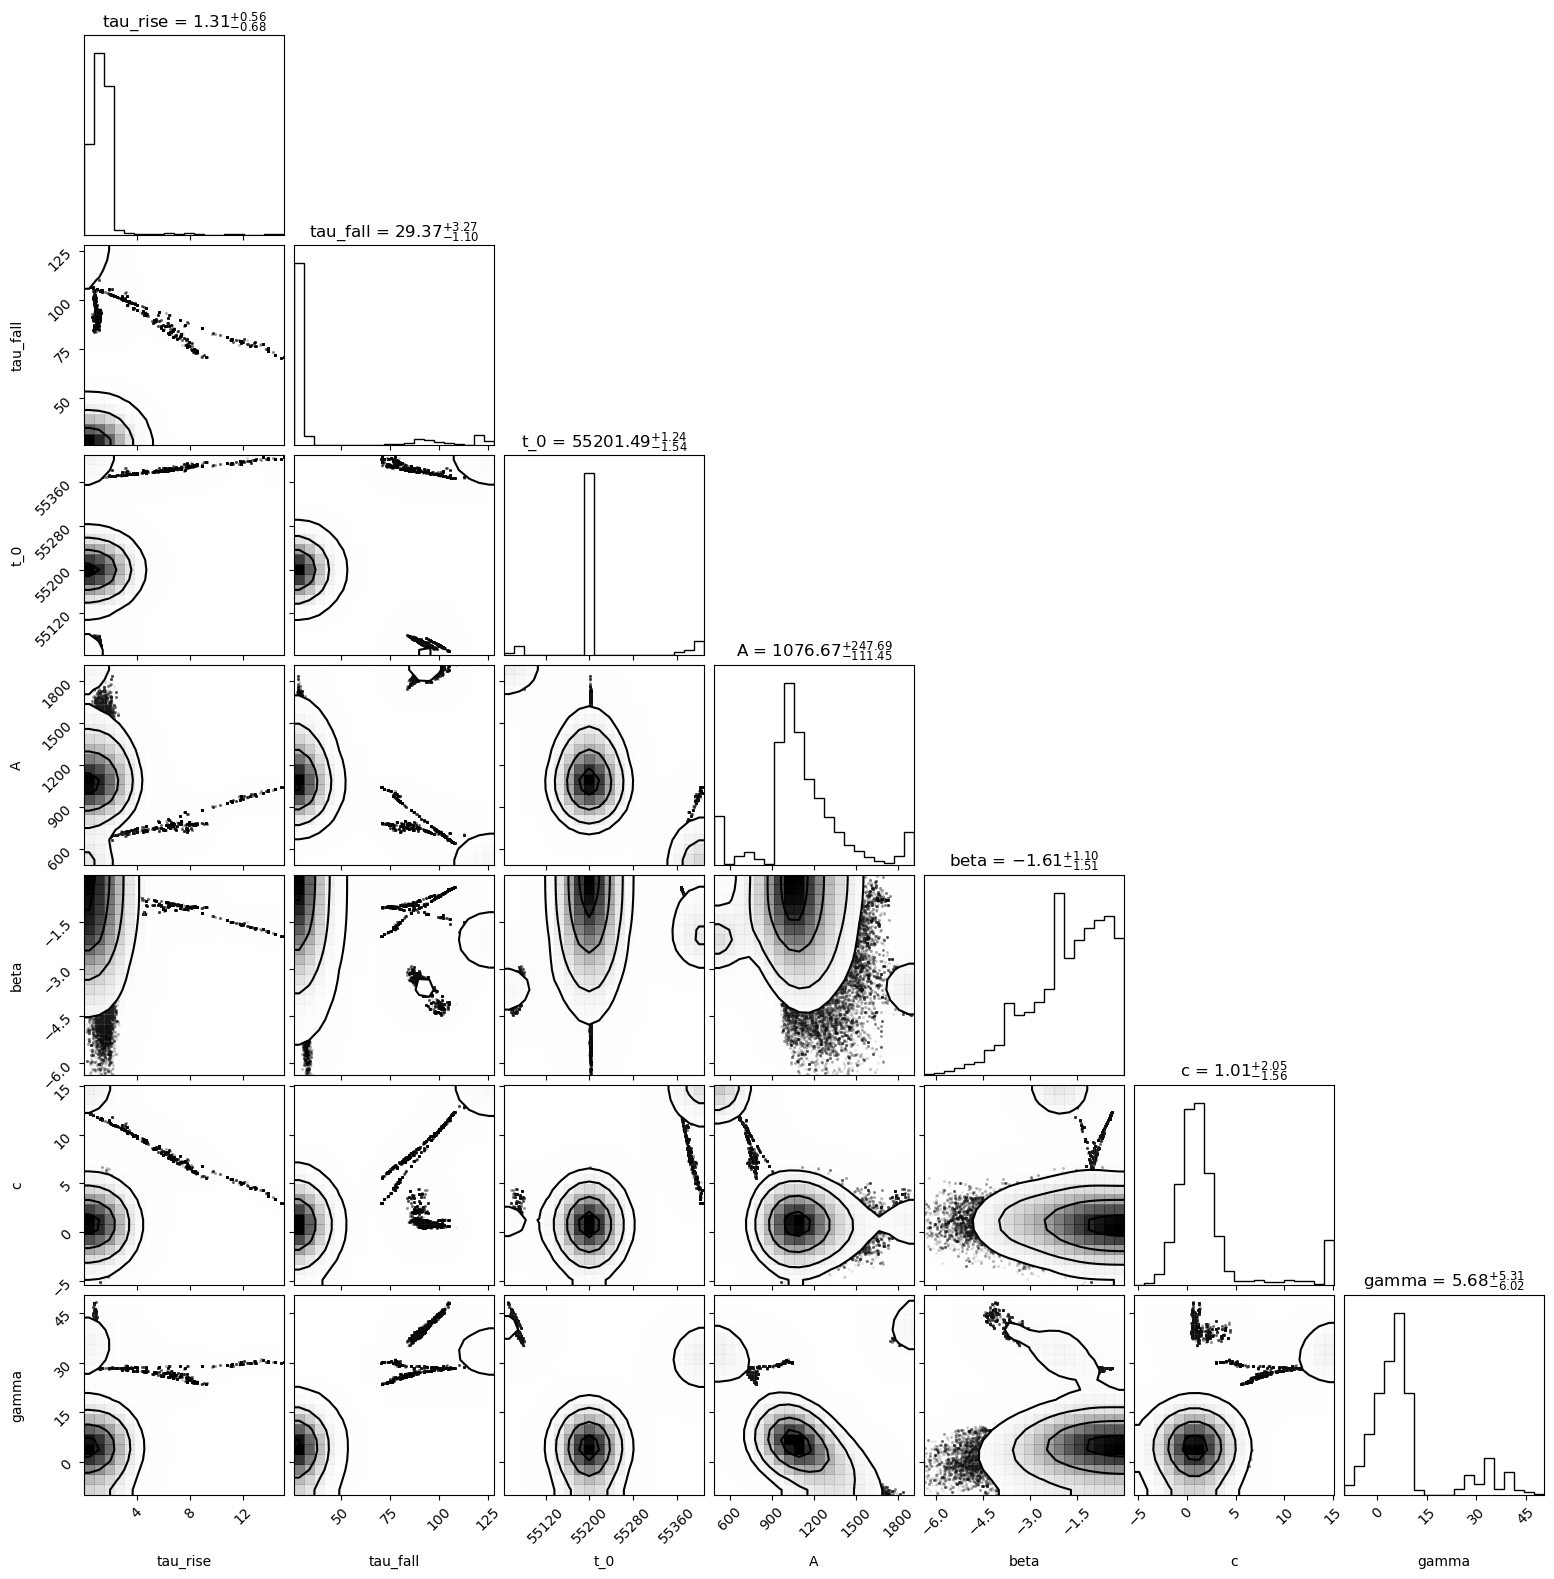

In [6]:
make_corner(samp1, prms)

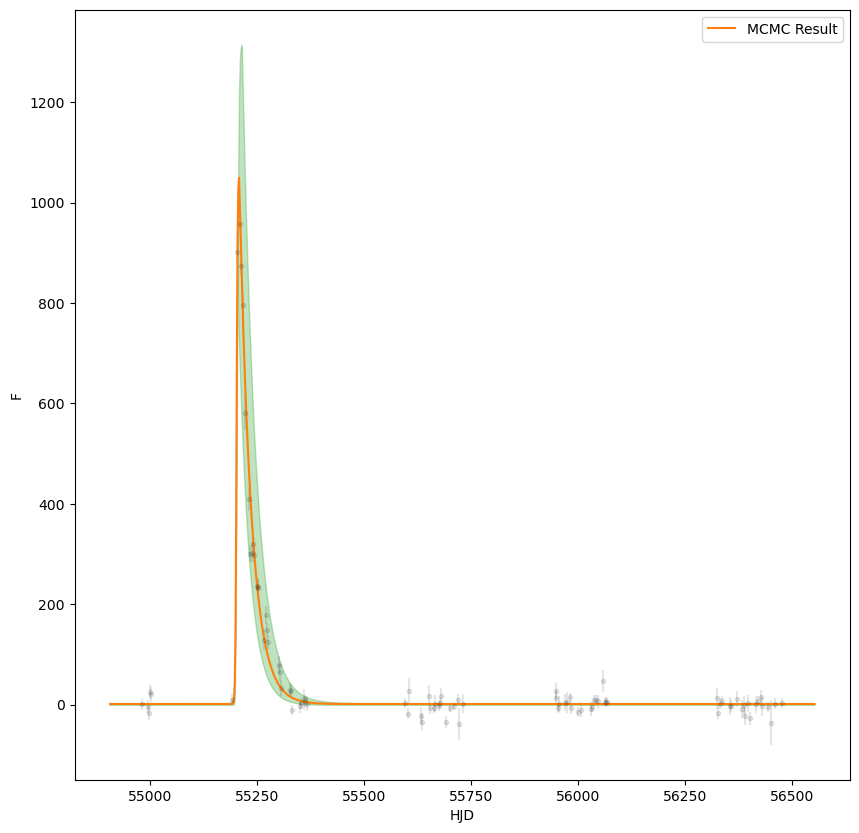

In [7]:
make_fig(data098[data098['FLT'] == 'g'], samp1)